### Dependencies & Prerequisites


In [50]:
#@title Import and set ups{ display-mode: "form" }

%matplotlib inline
from matplotlib import pylab as plt
import matplotlib.dates as mdates
import seaborn as sns

import pandas as pd 

import collections

import numpy as np
import tensorflow.compat.v2 as tf
import tf_keras
import tensorflow_probability as tfp

from tensorflow_probability import sts

### Plotting setup

Helper methods for plotting time series and forecasts.

In [51]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

sns.set_context("notebook", font_scale=1.)
sns.set_style("whitegrid")
%config InlineBackend.figure_format = 'retina'

In [52]:
def plot_forecast(x, y,
                  forecast_mean, forecast_scale, forecast_samples,
                  title, x_locator=None, x_formatter=None):
  """Plot a forecast distribution against the 'true' time series."""
  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]
  fig = plt.figure(figsize=(12, 6))
  ax = fig.add_subplot(1, 1, 1)

  num_steps = len(y)
  num_steps_forecast = forecast_mean.shape[-1]
  num_steps_train = num_steps - num_steps_forecast


  ax.plot(x, y, lw=2, color=c1, label='ground truth')

  forecast_steps = np.arange(
      x[num_steps_train],
      x[num_steps_train]+num_steps_forecast,
      dtype=x.dtype)

  ax.plot(forecast_steps, forecast_samples.T, lw=1, color=c2, alpha=0.1)

  ax.plot(forecast_steps, forecast_mean, lw=2, ls='--', color="red",
           label='forecast')
  ax.fill_between(forecast_steps,
                   forecast_mean-2*forecast_scale,
                   forecast_mean+2*forecast_scale, color=c2, alpha=0.2)

  ymin, ymax = min(np.min(forecast_samples), np.min(y)), max(np.max(forecast_samples), np.max(y))
  yrange = ymax-ymin
  ax.set_ylim([ymin - yrange*0.1, ymax + yrange*0.1])
  ax.set_title("{}".format(title))
  ax.legend()

  if x_locator is not None:
    ax.xaxis.set_major_locator(x_locator)
    ax.xaxis.set_major_formatter(x_formatter)
    fig.autofmt_xdate()

  return fig, ax

In [53]:
def plot_components(dates,
                    component_means_dict,
                    component_stddevs_dict,
                    x_locator=None,
                    x_formatter=None):
  """Plot the contributions of posterior components in a single figure."""
  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]

  axes_dict = collections.OrderedDict()
  num_components = len(component_means_dict)
  fig = plt.figure(figsize=(12, 2.5 * num_components))
  for i, component_name in enumerate(component_means_dict.keys()):
    component_mean = component_means_dict[component_name]
    component_stddev = component_stddevs_dict[component_name]

    ax = fig.add_subplot(num_components,1,1+i)
    ax.plot(dates, component_mean, lw=2)
    ax.fill_between(dates,
                     component_mean-2*component_stddev,
                     component_mean+2*component_stddev,
                     color=c2, alpha=0.5)
    ax.set_title(component_name)
    if x_locator is not None:
      ax.xaxis.set_major_locator(x_locator)
      ax.xaxis.set_major_formatter(x_formatter)
    axes_dict[component_name] = ax
  fig.autofmt_xdate()
  fig.tight_layout()
  return fig, axes_dict

In [54]:
def plot_one_step_predictive(dates, observed_time_series,
                             one_step_mean, one_step_scale,
                             x_locator=None, x_formatter=None):
  """Plot a time series against a model's one-step predictions."""

  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]

  fig=plt.figure(figsize=(12, 6))
  ax = fig.add_subplot(1,1,1)
  ax.plot(dates, observed_time_series, label="observed time series", color=c1)
  ax.plot(dates, one_step_mean, label="one-step prediction", color=c2)
  ax.fill_between(dates,
                  one_step_mean - one_step_scale,
                  one_step_mean + one_step_scale,
                  alpha=0.1, color=c2)
  ax.legend()

  if x_locator is not None:
    ax.xaxis.set_major_locator(x_locator)
    ax.xaxis.set_major_formatter(x_formatter)
    fig.autofmt_xdate()
  fig.tight_layout()
  return fig, ax

## Temperature (Monthly)

Monthly Prediction of Temperature 
Derived from the Mauna Loa Model of Official Tensorflow Documentation


### 1. Initial Data Setup

In [55]:
df = pd.read_csv("CombinedData.csv")[["datetime", "temp"]]
df["MonthYear"] = pd.DatetimeIndex(df["datetime"]).year * 10000 + pd.DatetimeIndex(df["datetime"]).month
mm_df = df.groupby(by="MonthYear").mean(numeric_only = True)
temp_by_month = mm_df["temp"].to_numpy()

print("Total Number of Months:", len(temp_by_month))
print("Total Number of Years:", len(temp_by_month) / 12)

num_forecast_steps = 12 * 5 # last X Years
temp_by_month_training_data = temp_by_month[:-num_forecast_steps]
temp_by_month_testing_data = temp_by_month[-num_forecast_steps - 1:]

temp_dates = np.arange("2000-01", "2024-01", dtype="datetime64[M]")
temp_loc = mdates.YearLocator(1) # Every Year
temp_fmt = mdates.DateFormatter('%Y')

Total Number of Months: 288
Total Number of Years: 24.0


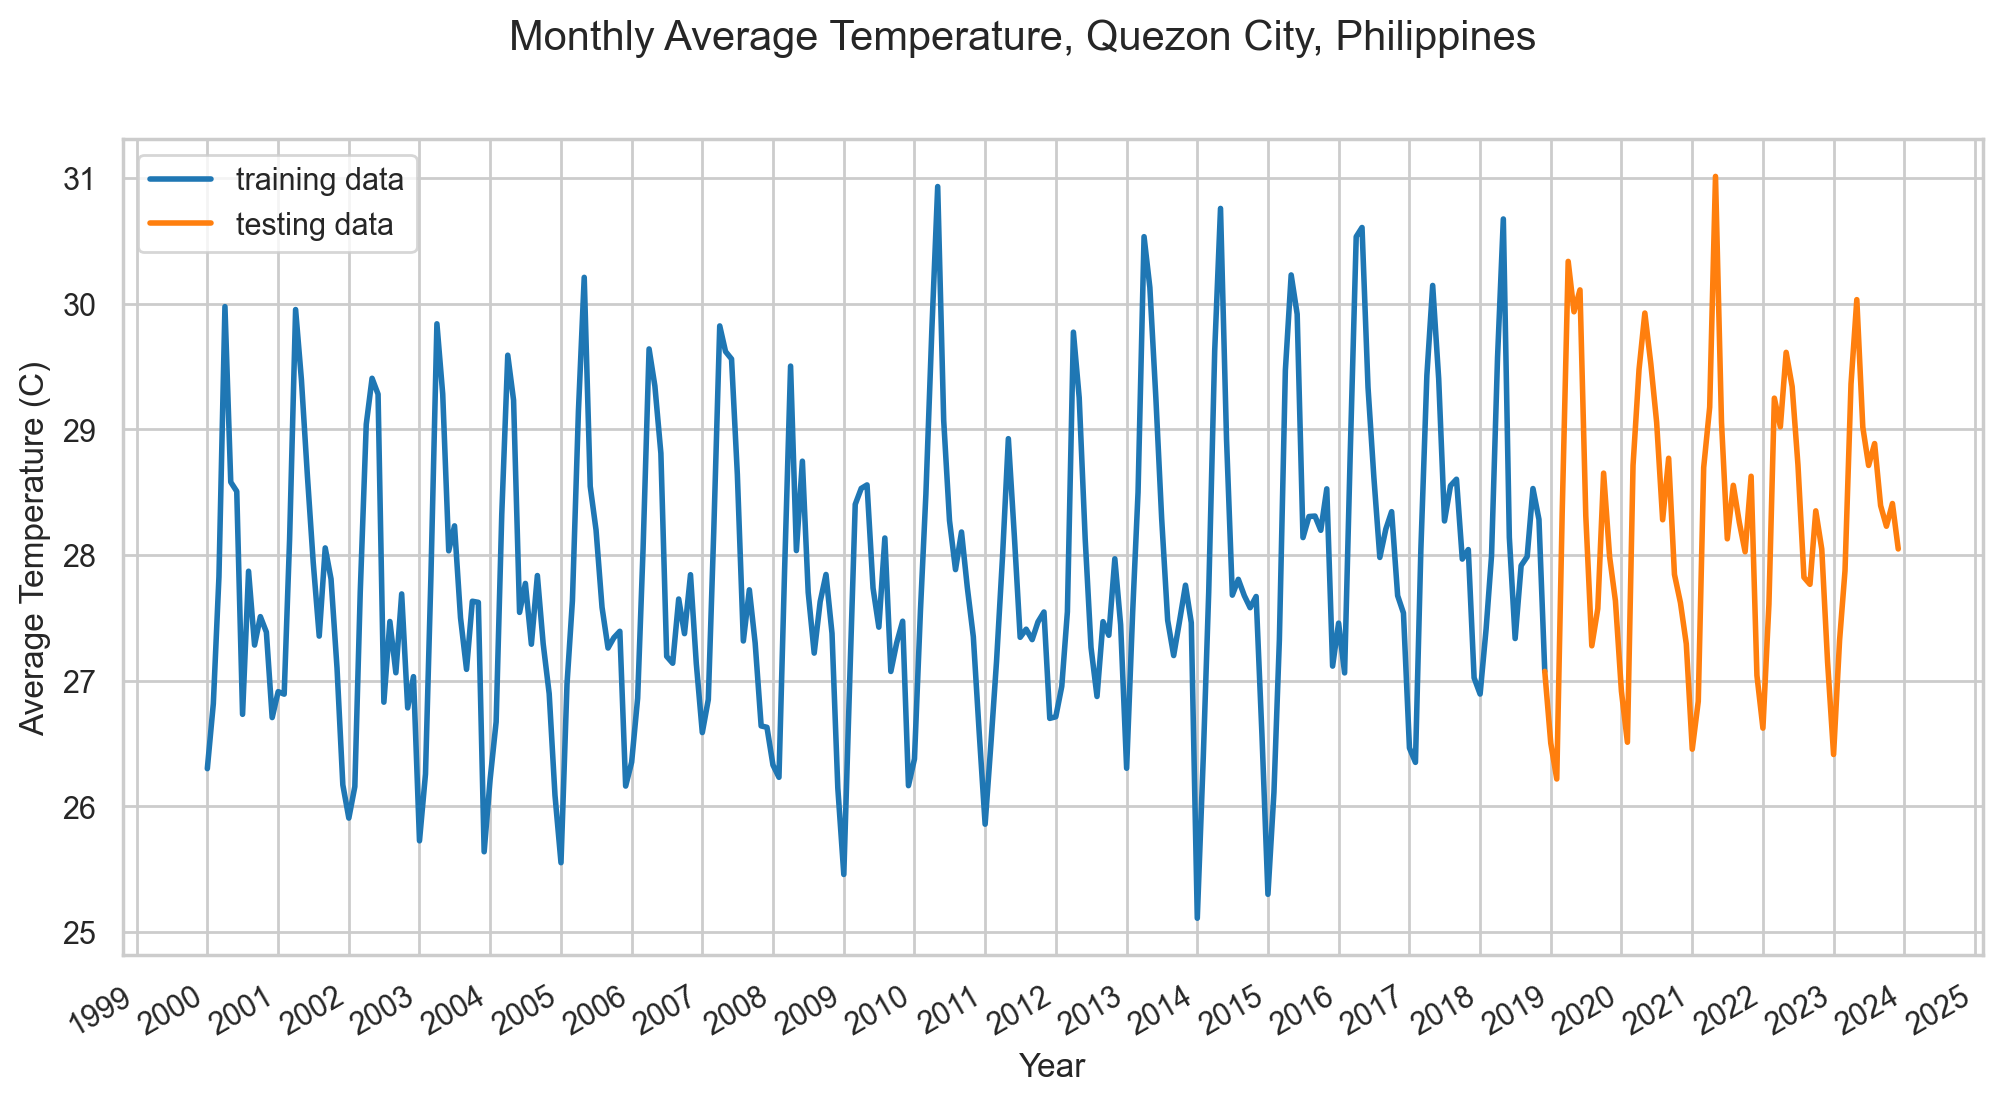

In [56]:
# Show Data
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(temp_dates[:-num_forecast_steps], temp_by_month_training_data, lw=2, label="training data")
ax.plot(temp_dates[-num_forecast_steps - 1:], temp_by_month_testing_data, lw=2, label="testing data")
ax.xaxis.set_major_locator(temp_loc)
ax.xaxis.set_major_formatter(temp_fmt)
ax.set_ylabel("Average Temperature (C)")
ax.set_xlabel("Year")
plt.legend()
fig.suptitle("Monthly Average Temperature, Quezon City, Philippines", fontsize=15)
fig.autofmt_xdate()


### Model and Fitting

We'll model this series with a local linear trend, plus a month-of-year seasonal effect.

In [57]:
# Simple Linear Trend with Seasonality
def build_model(observed_time_series):

  # Linear Trend
  # trend = sts.LocalLinearTrend(observed_time_series=observed_time_series)
  # trend = sts.SemiLocalLinearTrend(observed_time_series=observed_time_series)
  

  diff = num_forecast_steps - len(observed_time_series) + 2
  if diff < 0:
    print("Diff Result is:", diff)
    diff = 2
  
  print(diff)
  
  origlinRegMean = np.mean(observed_time_series)
  print(observed_time_series.shape[-1])
  linRegDataset = np.pad(observed_time_series, (0, num_forecast_steps), "constant")
  linRegDM = linRegDataset - origlinRegMean
  # print(len(observed_time_series))
  print(linRegDataset.shape)
  
  seasonal1 = tfp.sts.Seasonal(
      num_seasons=6, observed_time_series=observed_time_series, name="Half Year Seasonal")

  seasonal2 = tfp.sts.Seasonal(
      num_seasons=12, observed_time_series=observed_time_series, name="Annual Seasonal")
  
  linReg = tfp.sts.LinearRegression(
      design_matrix = tf.reshape(linRegDM, (-1, 1)), name = "Lin Reg"
  )
  
  autoReg = tfp.sts.Autoregressive(
    order = 2,
    observed_time_series = observed_time_series,
    name = "autoregressive"
  )
  
  # Add Both Seasonality and Trend
  model = sts.Sum([
    seasonal1, 
    seasonal2,
    linReg,
    autoReg
    ], observed_time_series=observed_time_series)

  return model

In [58]:
temp_model = build_model(temp_by_month_training_data)

# Build the variational surrogate posteriors `qs`.
variational_posteriors = tfp.sts.build_factored_surrogate_posterior(model=temp_model)

Diff Result is: -166
2
228
(288,)


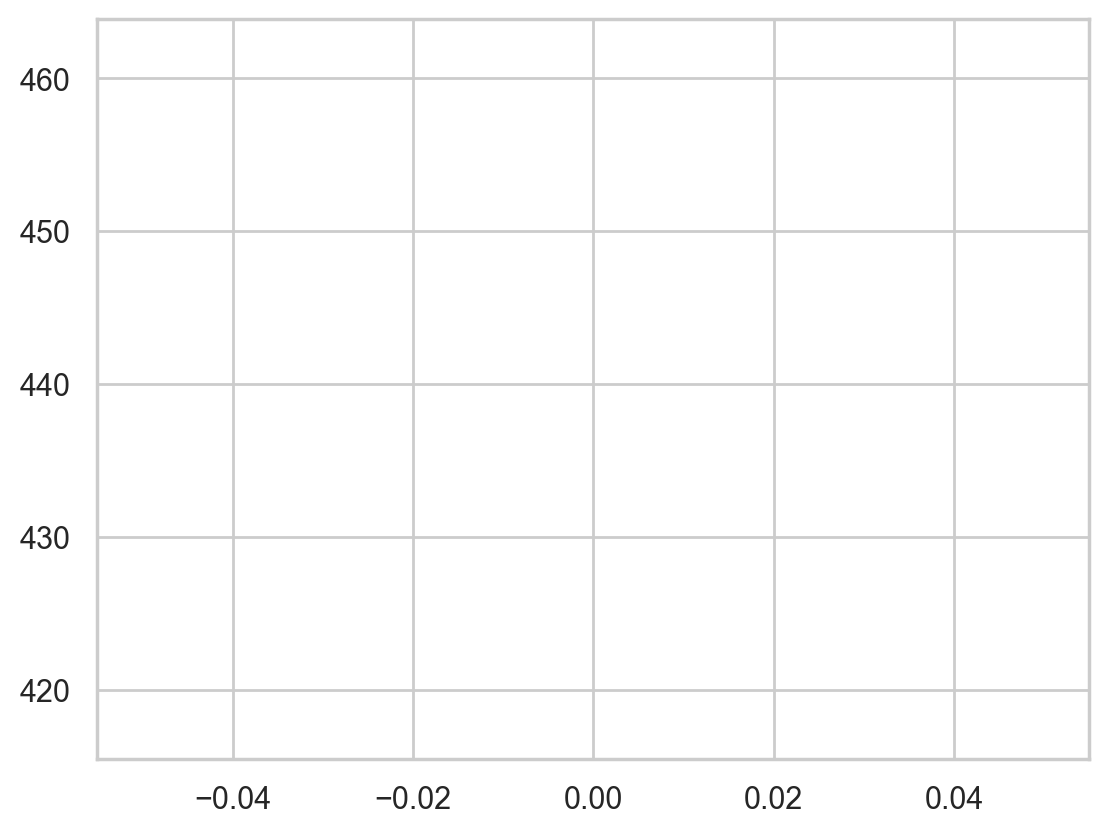

In [59]:
# Allow external control of optimization to reduce test runtimes.
num_variational_steps = 1
num_variational_steps = int(num_variational_steps)

# Build and optimize the variational loss function.
elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn = temp_model.joint_distribution(observed_time_series=temp_by_month_training_data).log_prob,
    surrogate_posterior = variational_posteriors,
    optimizer = tf_keras.optimizers.Adam(learning_rate=0.1),
    num_steps = num_variational_steps,
    # jit_compile = True)
)

plt.plot(elbo_loss_curve)
plt.show()



In [60]:
# Draw samples from the variational posterior.
q_samples_co2_ = variational_posteriors.sample(50)

In [61]:
# Parameters after Fitting
print("Inferred parameters:")
for param in temp_model.parameters:
    print("{}: {} +- {}".format(param.name, np.mean(q_samples_co2_[param.name], axis=0), np.std(q_samples_co2_[param.name], axis=0)))

Inferred parameters:
observation_noise_scale: 0.37418142649842134 +- 0.0038894868472124427
Half Year Seasonal/_drift_scale: 0.5241533921858779 +- 0.0047648283840272245
Annual Seasonal/_drift_scale: 0.06280811003407644 +- 0.0006372440660577125
Lin Reg/_weights: [-0.9901232] +- [0.0096285]
autoregressive/_coefficients: [ 0.44760857 -0.13261135] +- [0.00862901 0.01239108]
autoregressive/_level_scale: 1.0895977709877922 +- 0.009378411132808611


### Forecasting and criticism

Now let's use the fitted model to construct a forecast. We just call `tfp.sts.forecast`, which returns a TensorFlow Distribution instance representing the predictive distribution over future timesteps.

In [62]:
temp_by_month_training_data.shape

(228,)

In [63]:
temp_forecast_dist = tfp.sts.forecast(
    temp_model,
    observed_time_series = temp_by_month,
    parameter_samples=q_samples_co2_,
    num_steps_forecast= num_forecast_steps)
    # num_steps_forecast=12*50)
    # num_steps_forecast = len(temp_by_month) + 10)

InvalidArgumentError: {{function_node __wrapped__GatherV2_device_/job:localhost/replica:0/task:0/device:CPU:0}} indices = 288 is not in [0, 288) [Op:GatherV2] name: 

In [ ]:
num_samples = 10

temp_forecast_mean, temp_forecast_scale, temp_forecast_samples = (
    temp_forecast_dist.mean().numpy()[..., 0],
    temp_forecast_dist.stddev().numpy()[..., 0],
    # temp_forecast_dist.sample(num_samples).numpy()[..., 0])
    0)

In [ ]:
temp_forecast_mean.shape[-1]

60

In [ ]:
def plot_forecast(x, y, forecast_mean, forecast_scale, forecast_samples, title, x_locator=None, x_formatter=None):
    """Plot a forecast distribution against the 'true' time series."""
    colors = sns.color_palette()
    c1, c2 = colors[0], colors[1]
    fig = plt.figure(figsize=(24, 6))
    ax = fig.add_subplot(1, 1, 1)

    num_steps = len(y)
    num_steps_forecast = forecast_mean.shape[-1]
    num_steps_train = num_steps - num_steps_forecast



    ax.plot(x, y, lw=2, color=c1, label='ground truth')

    if forecast_mean.shape[-1] > num_steps:
        diff = forecast_mean.shape[-1] - num_steps
        forecast_steps = np.arange(x[0], x[len(y) - 1] + diff + 1, dtype = x.dtype)
        
    else:
        forecast_steps = np.arange(
            x[num_steps_train],
            x[num_steps_train]+num_steps_forecast,
            dtype=x.dtype)
        
    # Samples of Random Sht Predictions
    # ax.plot(forecast_steps, forecast_samples.T, lw=1, color=c2, alpha=0.1)
    
    # Main Prediction
    ax.plot(forecast_steps, forecast_mean, lw=2, ls='--', color="red",
            label='forecast')
    
    # ax.fill_between(forecast_steps,
    #                 forecast_mean-2*forecast_scale,
    #                 forecast_mean+2*forecast_scale, color=c2, alpha=0.2)

    ymin, ymax = min(np.min(forecast_mean), np.min(y)), max(np.max(forecast_mean), np.max(y))
    yrange = ymax-ymin
    ax.set_ylim([ymin - yrange*0.5, ymax + yrange*0.5])
    ax.set_title("{}".format(title))
    ax.legend()

    if x_locator is not None:
        ax.xaxis.set_major_locator(x_locator)
        ax.xaxis.set_major_formatter(x_formatter)
        fig.autofmt_xdate()

    return fig, ax

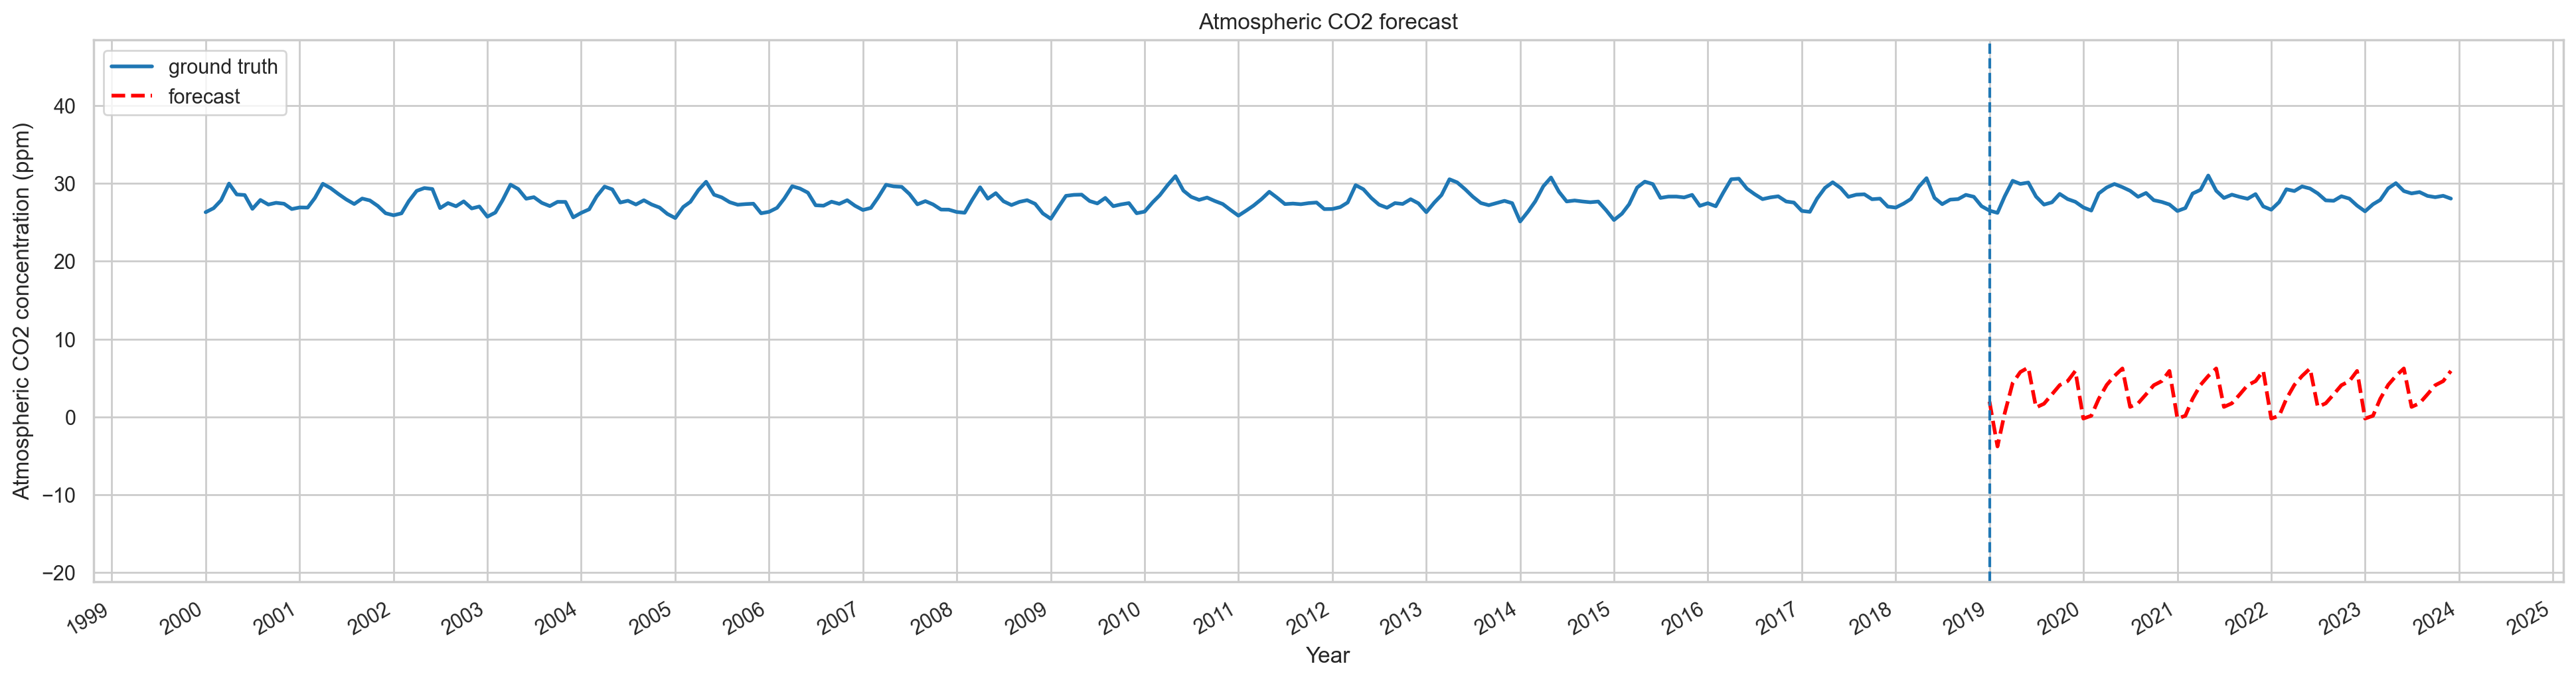

In [ ]:
fig, ax = plot_forecast(
    temp_dates, temp_by_month,
    temp_forecast_mean, temp_forecast_scale, temp_forecast_samples,
    x_locator=temp_loc,
    x_formatter=temp_fmt,
    title="Atmospheric CO2 forecast")

ax.axvline(temp_dates[-num_forecast_steps], linestyle="--")
ax.legend(loc="upper left")
ax.set_ylabel("Atmospheric CO2 concentration (ppm)")
ax.set_xlabel("Year")
lm = int(0.7 * len(temp_dates))
fig.autofmt_xdate()

We can further understand the model's fit by decomposing it into the contributions of individual time series:

In [ ]:
# Build a dict mapping components to distributions over
# their contribution to the observed signal.
component_dists = sts.decompose_by_component(
    temp_model,
    observed_time_series=temp_by_month,
    parameter_samples=q_samples_co2_)

In [ ]:
co2_component_means_, co2_component_stddevs_ = (
    {k.name: c.mean() for k, c in component_dists.items()},
    {k.name: c.stddev() for k, c in component_dists.items()})

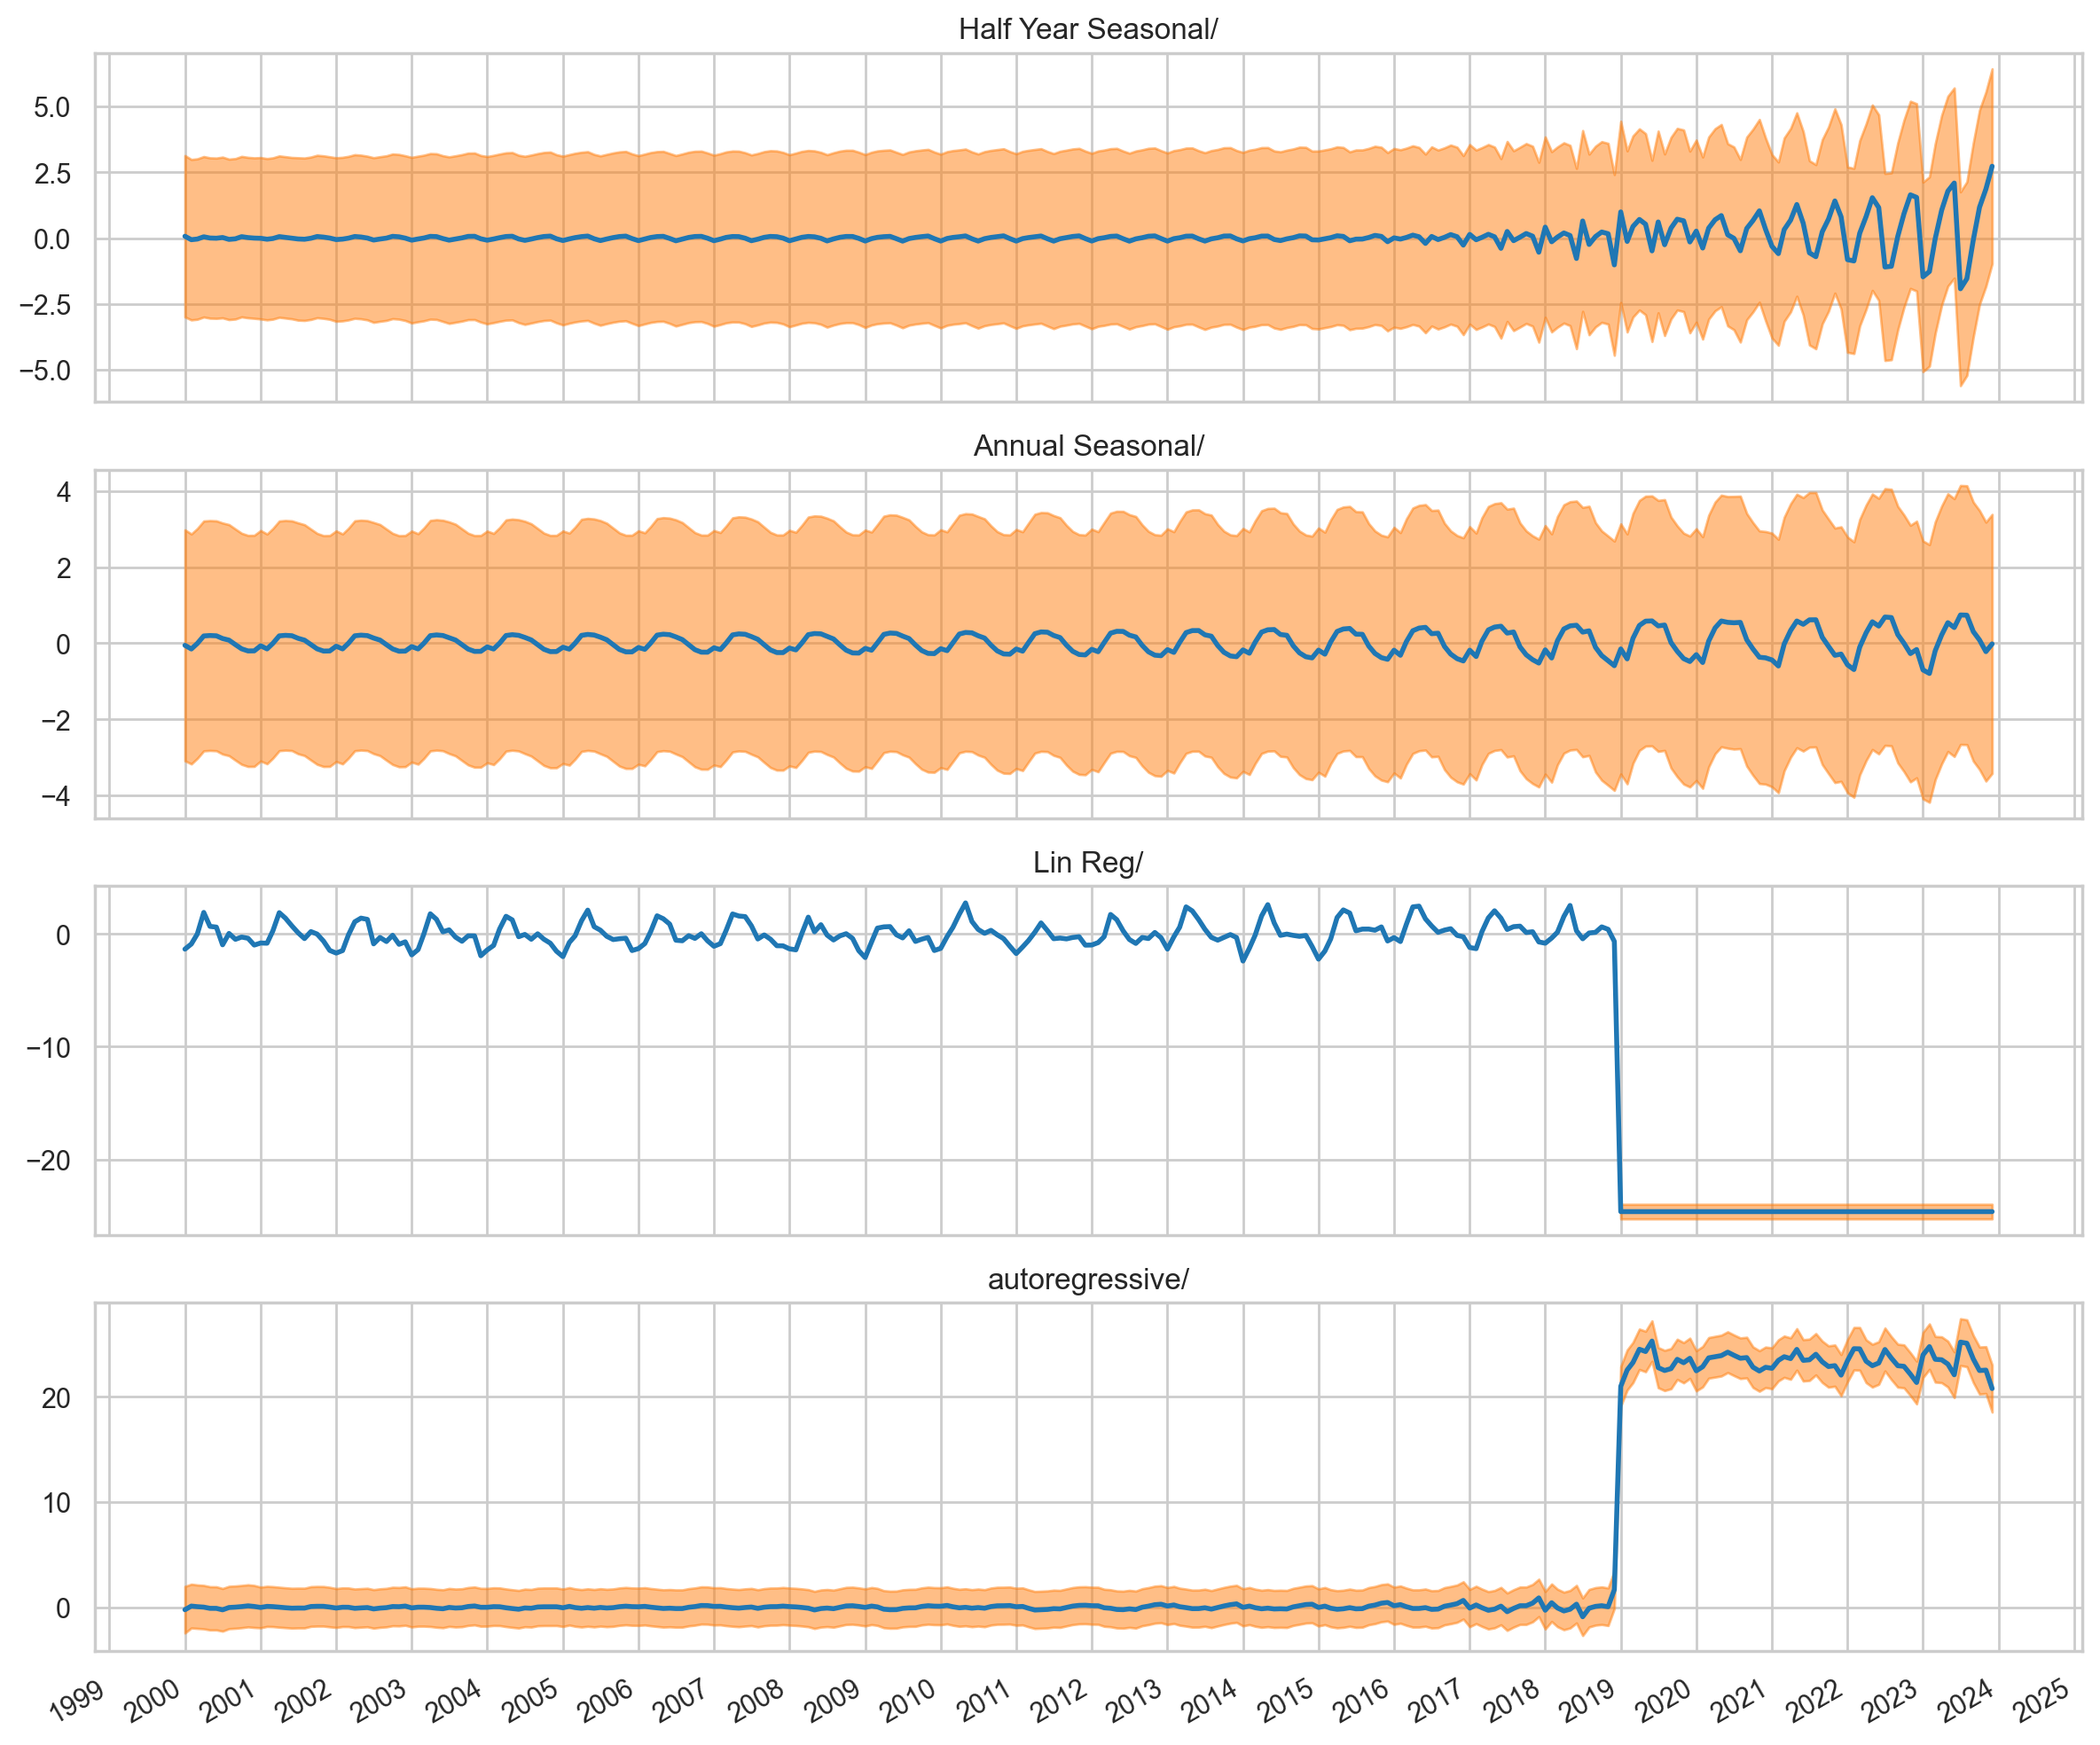

In [ ]:
_ = plot_components(temp_dates, co2_component_means_, co2_component_stddevs_,
                    x_locator=temp_loc, x_formatter=temp_fmt)

# Temperature (Daily)

Daily Temperature Auto Regressive Modelling